In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
from dataclasses import dataclass

In [20]:
# Constants
resources = {0: 'sheep', 1: 'wood', 2: 'wheat', 3: 'brick', 4: 'ore', 5: 'desert'}

class GameConfig:
    num_players: int = 3
    board_size: tuple = (5, 5)
    n_die: int = 2
    die_sides: int = 6
    max_turns: int = 100
    victory_points_to_win: int = 10
    def __init__(self, num_players, board_size, n_die, die_sides, max_turns, victory_points_to_win):
        self.num_players = num_players
        self.board_size = board_size
        self.n_die = n_die
        self.die_sides = die_sides
        self.max_turns = max_turns
        self.victory_points_to_win = victory_points_to_win

def probability_sum_equals(target, n_dice, die_sides):
    """Calculate probability of rolling a specific sum with n dice"""
    if target < n_dice or target > n_dice * die_sides:
        return 0.0
    
    count = 0
    total_outcomes = die_sides ** n_dice
    
    def count_ways(remaining_dice, current_sum, min_val, max_val):
        nonlocal count
        if remaining_dice == 0:
            if current_sum == target:
                count += 1
            return
        
        for val in range(min_val, max_val + 1):
            if current_sum + val + (remaining_dice - 1) * 1 <= target <= current_sum + val + (remaining_dice - 1) * die_sides:
                count_ways(remaining_dice - 1, current_sum + val, 1, die_sides)
    
    count_ways(n_dice, 0, 1, die_sides)
    return count / total_outcomes

class CatanGameState:
    """Main game state class containing all game data and logic"""
    
    def __init__(self, game_config=None, seed=None):
        self.config = game_config or GameConfig()
        
        # Set random seeds
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
        
        self._init_board()
        
        self._init_static_structures()
        
        self._init_dynamic_state()
        
        self._init_players()
        
        self._setup_initial_placements()
    
    def _init_board(self):
        """Initialize the game board"""
        self.game_shape = self.config.board_size
        self.n_die = self.config.n_die
        self.die_sides = self.config.die_sides
        self.max_roll = self.n_die * self.die_sides
        
        self.roll_grid = np.random.choice(
            np.concatenate([np.arange(self.n_die, 7), np.arange(8, self.max_roll + 1)]), # robber
            size=self.game_shape,
            p=[1/(self.max_roll - self.n_die) for _ in range(self.max_roll - self.n_die)]
        )
        
        resource_keys = [k for k, v in resources.items() if v != 'desert']
        self.resource_grid = np.random.choice(
            resource_keys,
            size=self.game_shape,
            p=[1/len(resource_keys)] * len(resource_keys)
        )
        
        center_row, center_col = self.game_shape[0] // 2, self.game_shape[1] // 2
        self.roll_grid[center_row, center_col] = 7
        self.resource_grid[center_row, center_col] = 5
        
        self.grid = np.stack((self.roll_grid, self.resource_grid), axis=-1)
        
        self.resource_locations = {resource: set(zip(*np.where(self.resource_grid == resource))) 
                                 for resource in resources}
        self.roll_locations = {roll: set(zip(*np.where(self.roll_grid == roll))) 
                             for roll in range(self.n_die, self.max_roll + 1)}
    
    def _init_static_structures(self):
        """Initialize static game structures that don't change"""
        # These are calculated once and never change
        self.rolling_prob = {i: probability_sum_equals(i, self.n_die, self.die_sides) 
                           for i in range(self.n_die, self.max_roll + 1)}
        
        # building costs
        self.building_costs = {
            "road": {"wood": 1, "brick": 1},
            "settlement": {"wood": 1, "brick": 1, "sheep": 1, "wheat": 1},
            "city": {"wheat": 2, "ore": 3},
            "development_card": {"sheep": 1, "wheat": 1, "ore": 1}
        }
        
        # development card deck distribution
        development_cards = {
            "knight": 14,
            "victory_point": 5,
            "road_building": 2,
            "year_of_plenty": 2,
            "monopoly": 2
        }
        
        self.dev_card_deck = []
        for card_type, count in development_cards.items():
            self.dev_card_deck.extend([card_type] * count)
        random.shuffle(self.dev_card_deck)
        
        self._calculate_board_structure()
    
    def _calculate_board_structure(self):
        """Calculate points, edges, and their relationships"""
        nrows, ncols = self.roll_grid.shape
        
        locations = np.argwhere(np.ones_like(self.roll_grid)).astype(float)
        even_rows = locations[:, 0] % 2 == 1
        locations[even_rows, 1] += 0.5
        
        self.point_index = {}
        self.points = []
        self.edge_index = {}
        self.edges = []
        self.point_to_edges = defaultdict(set)
        self.locations_to_neighboring_points = defaultdict(set)
        self.points_to_nodes = defaultdict(set)
        
        def normalize_point(pt, precision=6):
            return (round(pt[0], precision), round(pt[1], precision))
        
        def get_point_id(pt):
            if pt not in self.point_index:
                self.point_index[pt] = len(self.points)
                self.points.append(pt)
            return self.point_index[pt]
        
        def get_edge_id(p1, p2):
            e = tuple(sorted((p1, p2)))
            if e not in self.edge_index:
                self.edge_index[e] = len(self.edges)
                self.edges.append(e)
                self.point_to_edges[e[0]].add(self.edge_index[e])
                self.point_to_edges[e[1]].add(self.edge_index[e])
            return self.edge_index[e]
        
        for idx, point in enumerate(locations):
            x, y = point[1], point[0]
            
            edges_coords = [
                ((x+0.5, y-1/3), (x+0.5, y+1/3)),
                ((x+0.5, y+1/3), (x, y+2/3)),
                ((x, y+2/3), (x-0.5, y+1/3)),
                ((x-0.5, y+1/3), (x-0.5, y-1/3)),
                ((x-0.5, y-1/3), (x, y-2/3)),
                ((x, y-2/3), (x+0.5, y-1/3)),
            ]
            
            for p1, p2 in edges_coords:
                p1 = normalize_point(p1)
                p2 = normalize_point(p2)
                pid1 = get_point_id(p1)
                pid2 = get_point_id(p2)
                eid = get_edge_id(pid1, pid2)
                
                point_key = tuple(map(float, point))
                self.locations_to_neighboring_points[point_key].add(pid1)
                self.locations_to_neighboring_points[point_key].add(pid2)
                
                point_key = (int(np.floor(point[0])), int(np.floor(point[1])))
                self.points_to_nodes[pid1].add(point_key)
                self.points_to_nodes[pid2].add(point_key)
        
        self.point_to_edges = dict(self.point_to_edges)
        self.locations_to_neighboring_points = dict(self.locations_to_neighboring_points)
        self.points_to_nodes = dict(self.points_to_nodes)
        
        self.point_attractiveness = {
            point_id: sum(
                probability_sum_equals(self.grid[row, col, 0], self.n_die, self.die_sides)
                for row, col in self.points_to_nodes[point_id]
            )
            for point_id in range(len(self.points))
        }
        
        self._generate_ports()
    
    def _generate_ports(self):
        """Generate ports for the game"""
        self.ports = {}
        prob_of_general_port = 0.5
        np.random.seed(42)
        
        for point_id, edge_set in self.point_to_edges.items():
            if len(edge_set) == 2 and point_id < len(self.points):
                port_options = list(resources.values()) + ['generic']
                port_weights = [(1-prob_of_general_port)/len(resources)] * len(resources) + [prob_of_general_port]
                trade_resource = np.random.choice(port_options, p=port_weights)
                self.ports[point_id] = trade_resource
    
    def _init_dynamic_state(self):
        """Initialize dynamic game state variables"""

        self.point_owner = {}
        self.edge_owner = {}
        self.cities = {}  # point_id -> player (upgraded settlements)
        
        self.inventories = {player: {res: 0 for res in resources.values()}
                           for player in range(self.config.num_players)}
        self.player_dev_cards = {player: defaultdict(int) 
                               for player in range(self.config.num_players)}
        self.knights_played = {player: 0 for player in range(self.config.num_players)}
        
        # achievements
        self.player_scores = {player: 2 for player in range(self.config.num_players)}
        self.longest_road_info = (None, 0)  # (player, length)
        self.largest_army_info = (None, 0)  # (player, size)
        
        self.robber_location = (self.game_shape[0] // 2, self.game_shape[1] // 2)
        self.turn = 0
        self.current_player = 0
    
    def _init_players(self):
        """Initialize players"""
        self.players = [Player(id=i, game_state=self) for i in range(self.config.num_players)]
    
    def _setup_initial_placements(self):
        """Setup initial settlement placements"""
        self.player_positions = defaultdict(set)
        num_vertices = len(self.points)
        remaining = set(range(num_vertices))
        
        # first placement
        for player_id, player in enumerate(self.players):
            player_start = player.choose_starting_location(list(remaining))
            self.point_owner[player_start] = player_id
            self.player_positions[player_id].add(player_start)
            remaining.discard(player_start)
        
        # second placements (reverse order)
        for player_id in range(self.config.num_players - 1, -1, -1):
            player = self.players[player_id]
            player_second = player.choose_second_location(list(remaining))
            self.point_owner[player_second] = player_id
            self.player_positions[player_id].add(player_second)
            remaining.discard(player_second)
    
    def get_player_ports(self, player_id):
        """Get ports owned by a player"""
        player_ports = set()
        for point_id, owner in self.point_owner.items():
            if owner == player_id and point_id in self.ports:
                player_ports.add(self.ports[point_id])
        return player_ports
    
    def get_trade_ratio(self, player_id, resource_give):
        """Get bank trade ratio for a player"""
        player_ports = self.get_player_ports(player_id)
        
        # Check for specific resource port (2:1)
        if resource_give in player_ports:
            return 2
        
        # Check for generic port (3:1)
        if "generic" in player_ports:
            return 3
        
        # Default bank rate (4:1)
        return 4
    
    def can_afford(self, player_id, build_type):
        """Check if player can afford a building"""
        cost = self.building_costs[build_type]
        inv = self.inventories[player_id]
        return all(inv.get(res, 0) >= qty for res, qty in cost.items())
    
    def pay_resources(self, player_id, build_type):
        """Deduct resources for a build"""
        cost = self.building_costs[build_type]
        for res, qty in cost.items():
            self.inventories[player_id][res] -= qty
    
    def roll_dice(self):
        """Roll dice and return result"""
        rolls = np.random.randint(1, self.die_sides + 1, self.n_die)
        return int(np.sum(rolls))
    
    def distribute_resources(self, roll_result):
        """Distribute resources based on dice roll"""
        if roll_result == 7:
            return
        
        for location in self.roll_locations.get(roll_result, []):
            resource = resources[self.resource_grid[location]]
            loc_key = tuple(map(float, location))
            neighboring_points = self.locations_to_neighboring_points.get(loc_key, set())
            
            for point in neighboring_points:
                if point in self.point_owner:
                    player = self.point_owner[point]
                    # Cities produce 2 resources, settlements produce 1
                    multiplier = 2 if point in self.cities else 1
                    self.inventories[player][resource] = self.inventories[player].get(resource, 0) + multiplier
    
    def handle_robber(self, player_id):
        """Handle robber placement and stealing"""
        player = self.players[player_id]
        
        # Get valid robber locations
        all_locations = list(zip(*np.where(self.roll_grid != 7)))
        valid_locations = [loc for loc in all_locations if loc != self.robber_location]
        
        if valid_locations:
            robber_location = player.choose_robber_location(self.robber_location, valid_locations)
            self.robber_location = robber_location
            print(f"  / Player {player_id} moved robber to {robber_location}")
            
            # steal from an adjacent player
            neighboring_points = self.locations_to_neighboring_points.get(tuple(map(float, robber_location)), set())
            adjacent_players = set()
            for point in neighboring_points:
                if point in self.point_owner and self.point_owner[point] != player_id:
                    adjacent_players.add(self.point_owner[point])
            
            if adjacent_players:
                target = player.choose_steal_target(adjacent_players)
                if target is not None:
                    target_resources = [res for res, qty in self.inventories[target].items() if qty > 0]
                    if target_resources:
                        stolen_resource = random.choice(target_resources)
                        self.inventories[target][stolen_resource] -= 1
                        self.inventories[player_id][stolen_resource] = self.inventories[player_id].get(stolen_resource, 0) + 1
                        print(f"Player {player_id} stole {stolen_resource} from Player {target}")
    
    def discard_excess_cards(self, player_id):
        """Handle discarding cards when 7 is rolled and player has >7 cards"""
        total_cards = sum(self.inventories[player_id].values())
        if total_cards > 7:
            to_discard = total_cards // 2
            print(f"Player {player_id} must discard {to_discard} cards")
            
            player = self.players[player_id]
            discarded = player.choose_discard_cards(self.inventories[player_id], to_discard)
            
            for resource in discarded:
                self.inventories[player_id][resource] -= 1
    
    def calculate_longest_road(self, player_id):
        """Calculate the longest road for a player using DFS"""
        if not self.edge_owner:
            return 0
        
        # Get all edges owned by the player
        player_edges = {eid for eid, owner in self.edge_owner.items() if owner == player_id}
        
        if len(player_edges) < 5:  # Need at least 5 roads to win longest road
            return 0
        
        # Build adjacency graph of player's roads
        road_graph = defaultdict(set)
        for edge_id in player_edges:
            p1, p2 = self.edges[edge_id]
            road_graph[p1].add(p2)
            road_graph[p2].add(p1)
        
        def dfs_longest_path(start, visited, current_length):
            """DFS to find longest path from a starting point"""
            max_length = current_length
            
            for neighbor in road_graph[start]:
                if neighbor not in visited:
                    # Check if we can continue through this point
                    # Road is blocked if opponent has a settlement/city here
                    if neighbor in self.point_owner and self.point_owner[neighbor] != player_id:
                        continue
                    
                    visited.add(neighbor)
                    length = dfs_longest_path(neighbor, visited, current_length + 1)
                    max_length = max(max_length, length)
                    visited.remove(neighbor)
            
            return max_length
        
        # Try starting from each endpoint or branch point
        max_road_length = 0
        for start_point in road_graph:
            visited = {start_point}
            length = dfs_longest_path(start_point, visited, 0)
            max_road_length = max(max_road_length, length)
        return max_road_length
    
    def update_longest_road(self):
        """Update longest road achievement"""
        road_lengths = {}
        for player in range(self.config.num_players):
            road_lengths[player] = self.calculate_longest_road(player)
        
        # Find player with longest road (minimum 5 roads)
        max_length = max(road_lengths.values())
        if max_length >= 5:
            current_longest = self.longest_road_info[0]
            candidates = [p for p, length in road_lengths.items() if length == max_length]
            
            if len(candidates) == 1:
                new_longest = candidates[0]
                if current_longest != new_longest:
                    # Transfer longest road
                    if current_longest is not None:
                        self.player_scores[current_longest] -= 2
                    self.player_scores[new_longest] += 2
                    self.longest_road_info = (new_longest, max_length)
                    print(f"🛣️ Player {new_longest} now has the longest road ({max_length} segments)!")
                else:
                    # Same player still has it, just update the length
                    self.longest_road_info = (new_longest, max_length)
            else:
                # Handle ties
                if current_longest is None:
                    self.longest_road_info = (None, max_length)
                elif current_longest in candidates:
                    self.longest_road_info = (current_longest, max_length)
                else:
                    self.player_scores[current_longest] -= 2
                    self.longest_road_info = (None, max_length)
        else:
            # No one qualifies for longest road
            if self.longest_road_info[0] is not None:
                current_longest, _ = self.longest_road_info
                self.player_scores[current_longest] -= 2
                self.longest_road_info = (None, 0)
                print(f"🛣️ Player {current_longest} lost the longest road")
    
    def update_largest_army(self):
        """Update largest army achievement"""
        if not self.knights_played or max(self.knights_played.values()) == 0:
            max_knights = 0
        else:
            max_knights = max(self.knights_played.values())
        
        if max_knights >= 3:
            current_largest = self.largest_army_info[0]
            candidates = [p for p, count in self.knights_played.items() if count == max_knights]
            
            if len(candidates) == 1:
                new_largest = candidates[0]
                if current_largest != new_largest:
                    # Transfer largest army
                    if current_largest is not None:
                        self.player_scores[current_largest] -= 2
                    self.player_scores[new_largest] += 2
                    self.largest_army_info = (new_largest, max_knights)
                    print(f"⚔️ Player {new_largest} now has the largest army ({max_knights} knights)!")
                else:
                    # Same player still has it, just update the count
                    self.largest_army_info = (new_largest, max_knights)
            else:
                # Handle ties
                if current_largest is None:
                    self.largest_army_info = (None, max_knights)
                elif current_largest in candidates:
                    self.largest_army_info = (current_largest, max_knights)
                else:
                    self.player_scores[current_largest] -= 2
                    self.largest_army_info = (None, max_knights)
        else:
            # No one qualifies for largest army
            if self.largest_army_info[0] is not None:
                current_largest, _ = self.largest_army_info
                self.player_scores[current_largest] -= 2
                self.largest_army_info = (None, 0)
                print(f"⚔️ Player {current_largest} lost the largest army")
    
    def calculate_total_score(self, player_id):
        """Calculate total victory points for a player"""
        all_buildings = self.player_positions.get(player_id, set())
        cities = [pt for pt in all_buildings if pt in self.cities]
        settlements = [pt for pt in all_buildings if pt not in self.cities]
        
        building_points = len(settlements) + len(cities) * 2
        vp_card_points = self.player_dev_cards[player_id]['victory_point']
        longest_road_points = 2 if self.longest_road_info[0] == player_id else 0
        largest_army_points = 2 if self.largest_army_info[0] == player_id else 0
        
        return building_points + vp_card_points + longest_road_points + largest_army_points
    
    def is_game_over(self):
        """Check if game is over"""
        return (self.turn > self.config.max_turns or 
                any(self.calculate_total_score(player) >= self.config.victory_points_to_win 
                    for player in range(self.config.num_players)))
    
    def execute_trade(self, player_id, resource_give, resource_get):
        """Execute a bank trade"""
        ratio = self.get_trade_ratio(player_id, resource_give)

        if self.inventories[player_id].get(resource_give, 0) >= ratio:
            self.inventories[player_id][resource_give] -= ratio
            self.inventories[player_id][resource_get] = self.inventories[player_id].get(resource_get, 0) + 1
            print(f"  / Player {player_id} traded {ratio} {resource_give} for 1 {resource_get}")
            return True
        return False
    
    def execute_action(self, player_id, action):
        """Execute player building actions"""
        if action == "road":
            return self._build_road(player_id)
        elif action == "settlement":
            return self._build_settlement(player_id)
        elif action == "city":
            return self._build_city(player_id)
        elif action == "development_card":
            return self._buy_development_card(player_id)
        return False
    
    def _build_road(self, player_id):
        """Build a road for the player"""
        # Find buildable edges
        owned_points = [pt for pt, owner in self.point_owner.items() if owner == player_id]
        owned_edges = set(self.edge_owner.keys())

        possible_edges = set()
        for pt in owned_points:
            possible_edges.update(self.point_to_edges.get(pt, set()))

        # Also include edges adjacent to owned roads
        for edge, owner in self.edge_owner.items():
            if owner == player_id:
                edge_points = self.edges[edge]
                for point in edge_points:
                    possible_edges.update(self.point_to_edges.get(point, set()))

        buildable_edges = list(possible_edges - owned_edges)

        if buildable_edges:
            edge = random.choice(buildable_edges)
            self.edge_owner[edge] = player_id
            print(f"  / Player {player_id} built a road on edge {edge}")
            return True
        return False
    
    def _build_settlement(self, player_id):
        """Build a settlement for the player"""
        # Find valid settlement locations
        owned_edges = {e for e, owner in self.edge_owner.items() if owner == player_id}
        candidate_points = set()
        
        for edge in owned_edges:
            edge_points = self.edges[edge]
            candidate_points.update(edge_points)
        
        # remove points already owned
        owned_points = set(self.point_owner.keys())
        candidate_points -= owned_points
        
        # check for adjacent settlements
        valid_points = []
        for pt in candidate_points:
            adjacent_edges = self.point_to_edges.get(pt, set())
            adjacent_points = set()
            for edge in adjacent_edges:
                adjacent_points.update(self.edges[edge])
            adjacent_points.discard(pt)
            
            if not any(p in owned_points for p in adjacent_points):
                valid_points.append(pt)
        
        if valid_points:
            point = random.choice(valid_points)
            self.point_owner[point] = player_id
            self.player_positions[player_id].add(point)
            self.player_scores[player_id] += 1
            print(f"  / Player {player_id} built a settlement at point {point}")
            return True
        return False
    
    def _build_city(self, player_id):
        """Build a city for the player"""
        player_settlements = [pt for pt, owner in self.point_owner.items() 
                            if owner == player_id and pt not in self.cities]
        
        if player_settlements:
            point = random.choice(player_settlements)
            self.cities[point] = player_id
            self.player_scores[player_id] += 1  # Cities give additional points
            print(f"  / Player {player_id} upgraded settlement at point {point} to a city")
            return True
        return False
    
    def _buy_development_card(self, player_id):
        """Buy a development card for the player"""
        if self.dev_card_deck:
            card = self.dev_card_deck.pop()
            self.player_dev_cards[player_id][card] += 1
            print(f"  / Player {player_id} bought a {card} development card")
            
            # VP cards are immediate
            if card == "victory_point":
                self.player_scores[player_id] += 1
            
            return True
        else:
            print("No development cards left in deck")
        return False
    
    def play_knight_card(self, player_id):
        """Play a knight development card"""
        if self.player_dev_cards[player_id]["knight"] > 0:
            self.player_dev_cards[player_id]["knight"] -= 1
            self.knights_played[player_id] += 1
            
            # move robber and steal
            self.handle_robber(player_id)
            
            print(f"  / Player {player_id} played a Knight card (total: {self.knights_played[player_id]})")
            self.update_largest_army()
            return True
        return False

In [21]:
class Player:
    """Enhanced Player class with access to game state and advanced strategies"""
    
    def __init__(self, id, game_state, strategy="random"):
        self.id = id
        self.strategy = strategy
        self.color = f"#{np.random.randint(0, 0xFFFFFF):06x}"
        self.game_state = game_state
        self.development_cards_played_this_turn = []
        self.last_action_history = [] # track last actions
    
    def choose_starting_location(self, available_locations):
        """Choose initial settlement location"""
        if self.strategy == "random":
            return np.random.choice(available_locations)
        elif self.strategy == "greedy":
            return self._choose_best_location(available_locations)
        elif self.strategy == "balanced":
            return self._choose_balanced_location(available_locations)
        else:
            return np.random.choice(available_locations)
    
    def choose_second_location(self, available_locations):
        """Choose second settlement location with different strategy"""
        if self.strategy == "greedy":
            return self._choose_strategic_second_location(available_locations)
        else:
            return self.choose_starting_location(available_locations)
    
    def _choose_best_location(self, available_locations):
        """Helper to choose location with best resource probability"""
        if not available_locations:
            return None
        
        best_location = available_locations[0]
        best_attractiveness = self.game_state.point_attractiveness.get(best_location, 0)
        
        for location in available_locations:
            attractiveness = self.game_state.point_attractiveness.get(location, 0)
            if attractiveness > best_attractiveness:
                best_attractiveness = attractiveness
                best_location = location
        
        return best_location
    
    def _choose_balanced_location(self, available_locations):
        """Choose location balancing probability and resource diversity"""
        if not available_locations:
            return None
        
        best_location = available_locations[0]
        best_score = 0
        
        for location in available_locations:
            attractiveness = self.game_state.point_attractiveness.get(location, 0)

            adjacent_resources = set()
            for row, col in self.game_state.points_to_nodes.get(location, []):
                if 0 <= row < self.game_state.game_shape[0] and 0 <= col < self.game_state.game_shape[1]:
                    resource = self.game_state.resources[self.game_state.resource_grid[row, col]]
                    if resource != 'desert':
                        adjacent_resources.add(resource)
            
            diversity_bonus = len(adjacent_resources) * 0.1
            total_score = attractiveness + diversity_bonus
            
            if total_score > best_score:
                best_score = total_score
                best_location = location
        
        return best_location
    
    def _choose_strategic_second_location(self, available_locations):
        """Choose second location to complement first and potentially block opponents"""
        if not available_locations:
            return None
        
        first_settlement = list(self.game_state.player_positions[self.id])[0]
        first_resources = set()
        for row, col in self.game_state.points_to_nodes.get(first_settlement, []):
            if 0 <= row < self.game_state.game_shape[0] and 0 <= col < self.game_state.game_shape[1]:
                resource = self.game_state.resources[self.game_state.resource_grid[row, col]]
                if resource != 'desert':
                    first_resources.add(resource)
        
        best_location = available_locations[0]
        best_score = 0
        
        for location in available_locations:
            attractiveness = self.game_state.point_attractiveness.get(location, 0)
            
            location_resources = set()
            for row, col in self.game_state.points_to_nodes.get(location, []):
                if 0 <= row < self.game_state.game_shape[0] and 0 <= col < self.game_state.game_shape[1]:
                    resource = self.game_state.resources[self.game_state.resource_grid[row, col]]
                    if resource != 'desert':
                        location_resources.add(resource)
            
            # bonus for new resources not in first settlement
            new_resources = location_resources - first_resources
            diversity_bonus = len(new_resources) * 0.15 # this can be learned and tuned
            
            overlap_penalty = len(location_resources & first_resources) * 0.05 # learned and tuned potentially
            
            total_score = attractiveness + diversity_bonus - overlap_penalty
            
            if total_score > best_score:
                best_score = total_score
                best_location = location
        
        return best_location
    
    def choose_robber_location(self, current_location, valid_locations):
        """Choose where to place the robber"""
        if self.strategy == "random":
            return random.choice(valid_locations)
        elif self.strategy in ["greedy", "balanced"]:
            return self._choose_best_robber_location(current_location, valid_locations)
        else:
            return random.choice(valid_locations)
    
    def _choose_best_robber_location(self, current_location, valid_locations):
        """Choose robber location that hurts opponents most"""
        best_location = valid_locations[0]
        max_opponent_impact = 0
        
        for location in valid_locations:
            opponent_impact = 0
            loc_key = tuple(map(float, location))
            neighboring_points = self.game_state.locations_to_neighboring_points.get(loc_key, set())
            
            for point in neighboring_points:
                if point in self.game_state.point_owner:
                    owner = self.game_state.point_owner[point]
                    if owner != self.id:  # Only count opponents
                        # get expectation
                        roll_value = self.game_state.roll_grid[location]
                        probability = self.game_state.rolling_prob.get(roll_value, 0)
                        multiplier = 2 if point in self.game_state.cities else 1
                        
                        # extra penalty if opponent is leading
                        opponent_score = self.game_state.calculate_total_score(owner)
                        my_score = self.game_state.calculate_total_score(self.id)
                        leader_penalty = 1.5 if opponent_score >= my_score else 1.0
                        
                        opponent_impact += probability * multiplier * leader_penalty
            
            if opponent_impact > max_opponent_impact:
                max_opponent_impact = opponent_impact
                best_location = location
        
        return best_location
    
    def choose_steal_target(self, adjacent_players):
        """Choose which player to steal from"""
        if not adjacent_players:
            return None
        
        if self.strategy == "random":
            return random.choice(list(adjacent_players))
        elif self.strategy in ["greedy", "balanced"]:
            return self._choose_best_steal_target(adjacent_players)
        else:
            return random.choice(list(adjacent_players))
    
    def _choose_best_steal_target(self, adjacent_players):
        """Choose steal target with most resources or highest score"""
        best_target = None
        best_value = -1
        
        for player_id in adjacent_players:
            total_resources = sum(self.game_state.inventories[player_id].values())
            # consider their score as a tiebreaker
            score = self.game_state.calculate_total_score(player_id)
            my_score = self.game_state.calculate_total_score(self.id)
            
            threat_multiplier = 1.5 if score >= my_score else 1.0
            value = total_resources * 10 + score * threat_multiplier
            
            if value > best_value:
                best_value = value
                best_target = player_id
        
        return best_target
    
    def choose_discard_cards(self, inventory, num_to_discard):
        """Choose which cards to discard when robber is rolled"""
        discarded = []
        remaining_inventory = inventory.copy()
        
        if self.strategy == "random":
            # randomly discard
            available_cards = []
            for resource, count in remaining_inventory.items():
                available_cards.extend([resource] * count)
            
            discarded = random.sample(available_cards, min(num_to_discard, len(available_cards)))
        
        elif self.strategy in ["greedy", "balanced"]:
            # set up priority for discarding cards
            resource_priority = self._get_resource_priority()
            
            sorted_resources = sorted(remaining_inventory.items(), 
                                    key=lambda x: resource_priority.get(x[0], 0))
            
            for resource, count in sorted_resources:
                while count > 0 and len(discarded) < num_to_discard:
                    discarded.append(resource)
                    count -= 1
        
        return discarded
    
    def _get_resource_priority(self):
        """Get resource priority based on current needs"""
        # basic priority
        priority = {"sheep": 1, "wood": 1, "wheat": 1, "brick": 1, "ore": 1, "desert": 0}
        
        inventory = self.game_state.inventories[self.id]
        
        # set up a linear system to determine which build to optimize for
        # this will be implemented later

        # increase priority for resources needed for settlements / goal strategy, this part will be learned and tuned
        settlement_needs = {"wood": 1, "brick": 1, "sheep": 1, "wheat": 1}
        for res, need in settlement_needs.items():
            if inventory.get(res, 0) < need:
                priority[res] += 2
        
        # Increase priority for resources needed for cities
        city_needs = {"wheat": 2, "ore": 3}
        for res, need in city_needs.items():
            if inventory.get(res, 0) < need:
                priority[res] += 1
        
        # Increase priority for development cards
        dev_card_needs = {"sheep": 1, "wheat": 1, "ore": 1}
        dev_cards_owned = sum(self.game_state.player_dev_cards[self.id].values())
        if dev_cards_owned < 3:  # Encourage early dev card purchases
            for res, need in dev_card_needs.items():
                if inventory.get(res, 0) < need:
                    priority[res] += 1
        
        return priority
    
    def choose_trade(self):
        """Choose a trade to make with the bank"""
        if self.strategy == "random":
            return self._random_trade()
        elif self.strategy in ["greedy", "balanced"]:
            return self._greedy_trade()
        else:
            return None
    
    def _random_trade(self):
        """Make a random beneficial trade"""
        inventory = self.game_state.inventories[self.id]
        
        tradeable = []
        for resource in ["sheep", "wood", "wheat", "brick", "ore"]:
            ratio = self.game_state.get_trade_ratio(self.id, resource)
            if inventory.get(resource, 0) >= ratio:
                tradeable.append(resource)
        
        if not tradeable:
            return None
        
        give_resource = random.choice(tradeable)
        
        all_resources = ["sheep", "wood", "wheat", "brick", "ore"]
        get_resource = random.choice([r for r in all_resources if r != give_resource])
        
        return (give_resource, get_resource)
    
    def _greedy_trade(self):
        """Make a trade based on current needs"""
        inventory = self.game_state.inventories[self.id]
        priority = self._get_resource_priority()

        best_trade = None
        best_value = 0
        
        for give_resource in ["sheep", "wood", "wheat", "brick", "ore"]:
            ratio = self.game_state.get_trade_ratio(self.id, give_resource)
            if inventory.get(give_resource, 0) >= ratio:
                give_priority = priority.get(give_resource, 0)
                
                for get_resource in ["sheep", "wood", "wheat", "brick", "ore"]:
                    if get_resource != give_resource:
                        get_priority = priority.get(get_resource, 0)
                        
                        # value = what we gain - what we lose (accounting for ratio)
                        value = get_priority - (give_priority * ratio / 4)  # Normalize by 4:1 rate or maybe rate available to player for that resource
                        
                        if self._trade_helps_afford_building(give_resource, get_resource, ratio):
                            value += 2
                        
                        if value > best_value:
                            best_value = value
                            best_trade = (give_resource, get_resource)
        
        return best_trade
    
    def _trade_helps_afford_building(self, give_resource, get_resource, ratio):
        """Check if a trade helps us afford a building we couldn't before"""
        inventory = self.game_state.inventories[self.id].copy()
        
        inventory[give_resource] -= ratio
        inventory[get_resource] = inventory.get(get_resource, 0) + 1
        
        for building in ["settlement", "city", "development_card", "road"]:
            if not self.game_state.can_afford(self.id, building):
                cost = self.game_state.building_costs[building]
                if all(inventory.get(res, 0) >= qty for res, qty in cost.items()):
                    return True
        
        return False
    
    def choose_action(self):
        """Choose what action to take during turn"""
        if self.strategy == "random":
            return self._random_action()
        elif self.strategy == "greedy":
            return self._greedy_action()
        elif self.strategy == "balanced":
            return self._balanced_action()
        else:
            return self._random_action()
    
    def _random_action(self):
        """Choose a random affordable action"""
        possible_actions = []
        
        for action in ["road", "settlement", "city", "development_card"]:
            if self.game_state.can_afford(self.id, action):
                possible_actions.append(action)
        
        if possible_actions:
            return random.choice(possible_actions)
        return None
    
    def _greedy_action(self):
        """Choose action based on strategy priority"""
        inventory = self.game_state.inventories[self.id]
        
        action_priority = []
        
        if self.game_state.can_afford(self.id, "settlement"):
            action_priority.append("settlement")
        
        if self.game_state.can_afford(self.id, "city"):
            action_priority.append("city")
        
        # Roads for longest road and connectivity
        if self.game_state.can_afford(self.id, "road"):
            current_road_length = self.game_state.calculate_longest_road(self.id)
            if current_road_length >= 3: # can learn this, tune it
                action_priority.append("road")
        
        if self.game_state.can_afford(self.id, "development_card"):
            action_priority.append("development_card")
        
        if (self.game_state.can_afford(self.id, "road") and 
            "road" not in action_priority):
            action_priority.append("road")
        
        return action_priority[0] if action_priority else None
    
    def _balanced_action(self):
        """Choose action with balanced strategy considering game state"""
        my_score = self.game_state.calculate_total_score(self.id)
        max_opponent_score = max([self.game_state.calculate_total_score(p) 
                                 for p in range(self.game_state.config.num_players) 
                                 if p != self.id], default=0)
        
        # Adjust strategy based on position
        # all of these should be learned later on

        if my_score < max_opponent_score - 2:
            # Behind try to catch up
            return self._aggressive_action()
        elif my_score > max_opponent_score + 1:
            # ahead - be conservative
            return self._conservative_action()
        else:
            return self._greedy_action()
    
    def _aggressive_action(self):
        """More aggressive action prioritizing quick points"""
        if self.game_state.can_afford(self.id, "settlement"):
            return "settlement"
        if self.game_state.can_afford(self.id, "city"):
            return "city"
        if self.game_state.can_afford(self.id, "development_card"):
            return "development_card"
        if self.game_state.can_afford(self.id, "road"):
            return "road"
        return None
    
    def _conservative_action(self):
        """More conservative action focusing on resource generation"""
        if self.game_state.can_afford(self.id, "city"):
            return "city"
        if self.game_state.can_afford(self.id, "settlement"):
            return "settlement"
        if self.game_state.can_afford(self.id, "development_card"):
            return "development_card"
        if self.game_state.can_afford(self.id, "road"):
            current_road_length = self.game_state.calculate_longest_road(self.id)
            longest_road_holder = self.game_state.longest_road_info[0]
            if longest_road_holder != self.id and current_road_length >= 4:
                return "road"
        return None
    
    def should_play_development_card(self):
        """Decide whether to play a development card"""
        if self.strategy == "random":
            if self.game_state.player_dev_cards[self.id]["knight"] > 0:
                return random.choice([True, False])
        elif self.strategy in ["greedy", "balanced"]:
            return self._strategic_play_dev_card()
        
        return False
    
    def _strategic_play_dev_card(self):
        """Strategic development card play"""
        # if we can gain largest army or defend it, play knight
        if self.game_state.player_dev_cards[self.id]["knight"] > 0:
            current_largest = self.game_state.largest_army_info[0]
            my_knights = self.game_state.knights_played[self.id]
            
            if current_largest != self.id and my_knights + 1 >= 3:
                max_other_knights = max([self.game_state.knights_played[p] 
                                       for p in range(self.game_state.config.num_players) 
                                       if p != self.id], default=0)
                if my_knights + 1 > max_other_knights:
                    return True
            
            # play if we already have largest army and someone is catching up
            if current_largest == self.id:
                max_other_knights = max([self.game_state.knights_played[p] 
                                       for p in range(self.game_state.config.num_players) 
                                       if p != self.id], default=0)
                if max_other_knights >= my_knights:
                    return True
            
            # play if robber is on our best tile
            robber_loc = self.game_state.robber_location
            robber_key = tuple(map(float, robber_loc))
            neighboring_points = self.game_state.locations_to_neighboring_points.get(robber_key, set())
            
            # check if robber affects our settlements/cities
            for point in neighboring_points:
                if point in self.game_state.point_owner and self.game_state.point_owner[point] == self.id:
                    roll_value = self.game_state.roll_grid[robber_loc]
                    if self.game_state.rolling_prob.get(roll_value, 0) > 0.1: # High probability tile, could learn this threshold but not really necessary i dont think
                        return True
        
        return False
    
    def get_building_priorities(self):
        """Get current building priorities for this player"""
        my_score = self.game_state.calculate_total_score(self.id)
        my_settlements = len([p for p in self.game_state.player_positions.get(self.id, set()) 
                             if p not in self.game_state.cities])
        my_cities = len([p for p in self.game_state.player_positions.get(self.id, set()) 
                        if p in self.game_state.cities])
        
        priorities = {}
        
        # Settlement priority
        if my_settlements < 3:
            priorities["settlement"] = 10
        elif my_settlements < 5:
            priorities["settlement"] = 7
        else:
            priorities["settlement"] = 3
        
        # City priority
        if my_settlements > 0:
            priorities["city"] = 8
        else:
            priorities["city"] = 0
        
        # Road priority based on longest road potential
        current_road_length = self.game_state.calculate_longest_road(self.id)
        longest_road_holder = self.game_state.longest_road_info[0]
        
        if longest_road_holder != self.id and current_road_length >= 3:
            priorities["road"] = 6
        elif longest_road_holder == self.id:
            priorities["road"] = 4 # Maintain lead
        else:
            priorities["road"] = 2
        
        # Development card priority
        if my_score >= 7:
            priorities["development_card"] = 8 # Late game VP cards
        else:
            priorities["development_card"] = 5
        
        return priorities
    
    def get_total_resources(self):
        """Get total number of resource cards"""
        return sum(self.game_state.inventories[self.id].values())
    
    def get_victory_points(self):
        """Get current victory points"""
        return self.game_state.calculate_total_score(self.id)
    
    def get_resource_production_rate(self):
        """Calculate expected resource production per turn"""
        production = {"sheep": 0, "wood": 0, "wheat": 0, "brick": 0, "ore": 0}
        
        for point in self.game_state.player_positions.get(self.id, set()):
            multiplier = 2 if point in self.game_state.cities else 1
            
            for row, col in self.game_state.points_to_nodes.get(point, []):
                if 0 <= row < self.game_state.game_shape[0] and 0 <= col < self.game_state.game_shape[1]:
                    resource = self.game_state.resources[self.game_state.resource_grid[row, col]]
                    if resource != 'desert':
                        roll_value = self.game_state.roll_grid[row, col]
                        probability = self.game_state.rolling_prob.get(roll_value, 0)
                        production[resource] += probability * multiplier
        
        return production
    
    def is_close_to_winning(self):
        """Check if player is close to winning"""
        return self.get_victory_points() >= self.game_state.config.victory_points_to_win - 2
    
    def __str__(self):
        return f"Player {self.id} ({self.strategy}) - {self.get_victory_points()} VP"
    
    def __repr__(self):
        return self.__str__()

In [22]:
game = CatanGameState(game_config=
    GameConfig(
        num_players=3,
        board_size=(5, 5),
        n_die=2,
        die_sides=6,
        max_turns=100,
        victory_points_to_win=10
    )
)

In [43]:
def plot_state_and_index(game_state):
    """
    Plot the Catan game state using the CatanGameState object
    
    Args:
        game_state: CatanGameState object containing all game data
    """
    
    grid = game_state.grid
    roll_grid = grid[:, :, 0]
    resource_grid = grid[:, :, 1]
    nrows, ncols = roll_grid.shape

    # Create hex locations with offset for even rows
    locations = np.argwhere(np.ones_like(roll_grid)).astype(float)
    even_rows = locations[:, 0] % 2 == 1
    locations[even_rows, 1] += 0.5

    # Create the plot
    try:
        plt.figure(figsize=(ncols*2, nrows*2))
        plotted_lines = set()

        # Plot hexes
        for idx, point in enumerate(locations):
            x, y = point[1], point[0]  # Swap for plotting
            
            # Try to load resource image, fallback to colored circle if not found
            try:
                resource_code = int(grid[int(y), int(x), 1])
                resource_name = resources.get(resource_code, "unknown")
                img = mpimg.imread(f"resource_pngs/{resource_name}.png")
                
                size = .65
                img = img[::-1, :, :]  # Flip vertically
                plt.imshow(img, extent=[x - size/2, x + size/2, y - size/2, y + size/2], 
                          zorder=1, origin='upper')
            except:
                # Fallback: draw colored circle for resource
                resource_colors = {0: 'lightgreen', 1: 'brown', 2: 'saddlebrown',
                                   3: 'wheat', 4: 'red', 5: 'gray'}
                resource_code = int(grid[int(y), int(x), 1])
                color = resource_colors.get(resource_code, 'white')
                circle = plt.Circle((x, y), 0.4, color=color, alpha=0.7, zorder=1)
                plt.gca().add_patch(circle)
            
            # Add roll number
            roll_num = int(roll_grid[int(y), int(x)])
            if roll_num != 7:  # Don't show roll number for desert/robber
                plt.text(x, y, str(roll_num), color='white', fontsize=12, 
                        zorder=2, ha='center', va='center', weight='bold')
            
            # Show robber location
            if (int(y), int(x)) == game_state.robber_location:
                plt.text(x, y + 0.15, "🔴", fontsize=16, zorder=3, ha='center', va='center')

        # Plot edges (roads)
        for edge_id, edge_points in enumerate(game_state.edges):
            p1_id, p2_id = edge_points
            if p1_id < len(game_state.points) and p2_id < len(game_state.points):
                p1 = game_state.points[p1_id]
                p2 = game_state.points[p2_id]
                
                # Determine edge color based on owner
                edge_color = 'lightgray'
                edge_width = 1
                edge_alpha = 0.3
                
                if edge_id in game_state.edge_owner:
                    player_id = game_state.edge_owner[edge_id]
                    edge_color = game_state.players[player_id].color
                    edge_width = 3
                    edge_alpha = 0.8

                # Plot edge
                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-', 
                        color=edge_color, alpha=edge_alpha, linewidth=edge_width, zorder=3)

        # Plot settlements and cities
        for point_id, player_id in game_state.point_owner.items():
            if point_id < len(game_state.points):
                px, py = game_state.points[point_id]
                p_color = game_state.players[player_id].color

                # Check if it's a city (larger marker)
                if point_id in game_state.cities:
                    marker_size = 120
                    marker = 's'
                    label = f"City (P{player_id})"
                else:
                    marker_size = 80
                    marker = 'o'
                    label = f"Settlement (P{player_id})"
                
                plt.scatter(px, py, c=p_color, s=marker_size, 
                          marker=marker, zorder=4, alpha=1, edgecolors='black', linewidth=2)

        # Plot ports
        for point_id, port_type in game_state.ports.items():
            if point_id < len(game_state.points):
                x, y = game_state.points[point_id]
                
                # Draw port indicator
                plt.scatter(x, y, marker='D', s=60, color='navy', 
                           alpha=0.8, zorder=2, edgecolors='white')
                
                # Add port text
                if port_type == 'generic':
                    plt.text(x, y-0.25, "3:1", fontsize=7, ha='center', 
                            color="white", weight='bold', zorder=5,
                            bbox=dict(boxstyle="round,pad=0.1", facecolor='navy', alpha=0.8))
                else:
                    plt.text(x, y-0.25, f"2:1\n{port_type[:4]}", fontsize=6, 
                            ha='center', color="white", weight='bold', zorder=5,
                            bbox=dict(boxstyle="round,pad=0.1", facecolor='navy', alpha=0.8))

        plt.gca().invert_yaxis()
        plt.axis('equal')
        
        # Create title with game info
        turn_info = f"Turn {game_state.turn}, Player {game_state.current_player}'s turn"
        plt.title(f"Settlers of Catan Board - {turn_info}", fontsize=14)
        
        # Create legend with player info
        legend_elements = []
        for player in game_state.players:
            score = game_state.calculate_total_score(player.id)
            total_resources = sum(game_state.inventories[player.id].values())
            knights = game_state.knights_played[player.id]
            
            label = f'Player {player.id}: {score}VP, {total_resources}cards, {knights}knights'
            legend_elements.append(plt.scatter([], [], c=player.color, s=100, label=label))
        
        # Add special achievements to legend
        longest_road_player, longest_road_length = game_state.longest_road_info
        largest_army_player, largest_army_size = game_state.largest_army_info
        
        achievement_text = []
        if longest_road_player is not None:
            achievement_text.append(f"Longest Road: Player {longest_road_player} ({longest_road_length})")
        if largest_army_player is not None:
            achievement_text.append(f"Largest Army: Player {largest_army_player} ({largest_army_size})")
        
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        # Add achievement text
        if achievement_text:
            plt.figtext(0.02, 0.02, '\n'.join(achievement_text), fontsize=10, 
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        
        # Only show plot if running interactively
        try:
            if plt.get_backend() != 'Agg':
                plt.show()
        except:
            pass  # Don't show if no display available
            
    except Exception as e:
        print(f"Plotting failed: {e}")
        import traceback
        traceback.print_exc()

def print_game_state(game_state):
    """
    Print a text summary of the current game state
    """
    print(f"\n{'='*60}")
    print(f"CATAN GAME STATE - Turn {game_state.turn}")
    print(f"Current Player: {game_state.current_player}")
    print(f"{'='*60}")
    
    # Player information
    for player in game_state.players:
        score = game_state.calculate_total_score(player.id)
        print(f"\nPlayer {player.id} ({player.strategy}):")
        print(f"  Victory Points: {score}")
        print(f"  Resources: {dict(game_state.inventories[player.id])}")
        print(f"  Knights Played: {game_state.knights_played[player.id]}")
        print(f"  Dev Cards: {dict(game_state.player_dev_cards[player.id])}")
        #if game_state.longest_road_info[0] == player.id or game_state.largest_army_info[0] == player.id:
            #print(f"  Achievements: {'Longest Road' if game_state.longest_road_info[0] == player.id else ''} {'Largest Army' if game_state.largest_army_info[0] == player.id else ''}".strip())
        
        # Buildings
        settlements = [p for p in game_state.player_positions.get(player.id, set()) 
                      if p not in game_state.cities]
        cities = [p for p in game_state.player_positions.get(player.id, set()) 
                 if p in game_state.cities]
        roads = [e for e, owner in game_state.edge_owner.items() if owner == player.id]
        
        print(f"  Buildings: {len(settlements)} settlements, {len(cities)} cities, {len(roads)} roads")
        
        # Ports
        player_ports = game_state.get_player_ports(player.id)
        if player_ports:
            print(f"  Ports: {list(player_ports)}")
    
    # Special achievements
    print(f"\nSpecial Achievements:")
    longest_road_player, longest_road_length = game_state.longest_road_info
    if longest_road_player is not None:
        print(f"  Longest Road: Player {longest_road_player} ({longest_road_length} segments)")
    
    largest_army_player, largest_army_size = game_state.largest_army_info
    if largest_army_player is not None:
        print(f"  Largest Army: Player {largest_army_player} ({largest_army_size} knights)")
    
    print(f"\nRobber Location: {game_state.robber_location}")
    print(f"Development Cards Remaining: {len(game_state.dev_card_deck)}")
    print(f"{'='*60}")

In [44]:
def demo_game_plotting():
    """
    Demonstrate the plotting function with a sample game
    """
    
    # Create a sample game
    config = GameConfig(
        num_players=5,
        board_size=(5,5),
        n_die=2,
        die_sides=6,
        max_turns=500,
        victory_points_to_win=10
    )
    
    game_state = CatanGameState(config, seed=42)
    
    # Play a few turns to generate some game state
    turn = 0
    while not game_state.is_game_over():
        print(f"Turn {turn+1}")
        for player_id in range(game_state.config.num_players):
            game_state.turn = turn
            game_state.current_player = player_id

            # Roll dice and distribute resources
            roll = game_state.roll_dice()
            print(f" - Player {player_id} rolled a {roll}")

            if roll == 7:
                # Handle robber
                for pid in range(game_state.config.num_players):
                    game_state.discard_excess_cards(pid)
                game_state.handle_robber(player_id)
            else:
                game_state.distribute_resources(roll)

            # Try to make a trade
            player = game_state.players[player_id]
            trade = player.choose_trade()
            if trade:
                give_res, get_res = trade
                game_state.execute_trade(player_id, give_res, get_res)

            # Try to build something
            action = player.choose_action()
            if action and game_state.can_afford(player_id, action):
                game_state.pay_resources(player_id, action)
                success = game_state.execute_action(player_id, action)
                if success:
                    game_state.update_longest_road()

            # Try to play development cards
            if player.should_play_development_card():
                game_state.play_knight_card(player_id)

            # Check for game over
            if game_state.is_game_over():
                print("Game over!")
                break
        turn += 1

    print_game_state(game_state)

    plot_state_and_index(game_state)
    
    return game_state

Turn 1
 - Player 0 rolled a 6
 - Player 1 rolled a 6
 - Player 2 rolled a 5
 - Player 3 rolled a 8
 - Player 4 rolled a 3
Turn 2
 - Player 0 rolled a 7
  / Player 0 moved robber to (np.int64(3), np.int64(4))
 - Player 1 rolled a 6
 - Player 2 rolled a 8
  / Player 2 built a road on edge 1
 - Player 3 rolled a 9
 - Player 4 rolled a 9
  / Player 4 traded 3 sheep for 1 ore
Turn 3
 - Player 0 rolled a 5
  / Player 0 traded 2 brick for 1 wheat
 - Player 1 rolled a 6
 - Player 2 rolled a 8
 - Player 3 rolled a 12
  / Player 3 traded 2 wheat for 1 wood
  / Player 3 built a road on edge 67
 - Player 4 rolled a 6
Turn 4
 - Player 0 rolled a 11
  / Player 0 traded 4 sheep for 1 ore
  / Player 0 bought a road_building development card
 - Player 1 rolled a 4
 - Player 2 rolled a 6
 - Player 3 rolled a 8
 - Player 4 rolled a 10
  / Player 4 traded 3 sheep for 1 brick
Turn 5
 - Player 0 rolled a 10
 - Player 1 rolled a 7
  / Player 1 moved robber to (np.int64(4), np.int64(1))
Player 1 stole brick f

/var/folders/x6/8q6l_bds66nct8y8r0xf2cp00000gn/T/ipykernel_11713/1220420733.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


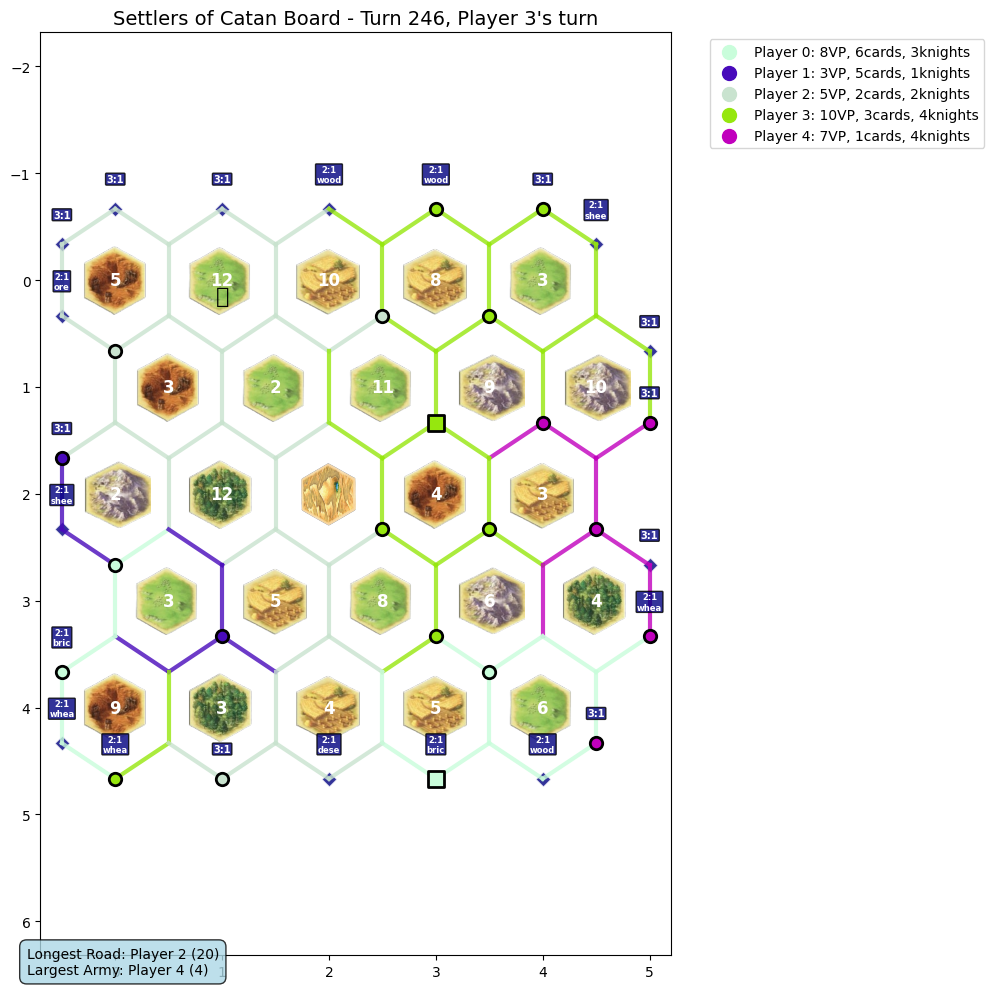

In [45]:
state = demo_game_plotting()

(array([17., 24., 21., 26., 25., 18., 13., 11.,  4.,  1.]),
 array([0.02777778, 0.06944444, 0.11111111, 0.15277778, 0.19444444,
        0.23611111, 0.27777778, 0.31944444, 0.36111111, 0.40277778,
        0.44444444]),
 <BarContainer object of 10 artists>)

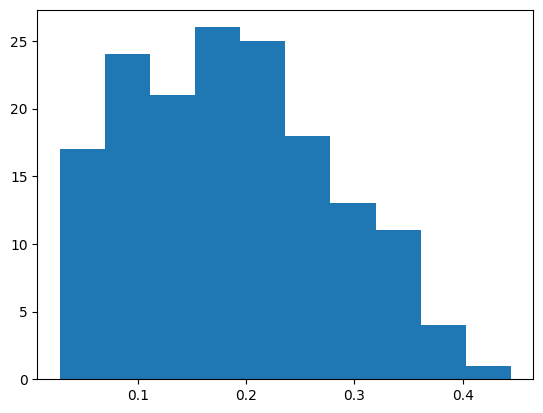

In [35]:
plt.hist(state.point_attractiveness.values(), bins = 10)

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple, defaultdict
import random
import pickle
import json
import matplotlib.pyplot as plt
from pathlib import Path
import time

# Import your existing classes
# from your_game_module import CatanGameState, GameConfig, Player, resources

# Experience tuple for replay buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class CatanStateEncoder:
    """Encodes Catan game state into feature vector for neural network"""
    
    def __init__(self, num_players=3, board_size=(5, 5)):
        self.num_players = num_players
        self.board_size = board_size
        self.feature_size = self._calculate_feature_size()
    
    def _calculate_feature_size(self):
        """Calculate total feature vector size"""
        # Player features (per player): resources(6) + buildings(3) + dev_cards(5) + other(8) = 22
        player_features = 22 * self.num_players
        
        # Board features: resource_grid + roll_grid + ownership + robber = board_size^2 * 4
        board_features = self.board_size[0] * self.board_size[1] * 4
        
        # Game state features: turn, special_cards, deck_size, etc. = 12
        game_features = 12
        
        return player_features + board_features + game_features
    
    def encode(self, game_state, player_id):
        """Encode game state into feature vector from player's perspective"""
        features = []
        
        # 1. Player Features (normalize player order so current player is always first)
        player_order = [(player_id + i) % self.num_players for i in range(self.num_players)]
        
        for pid in player_order:
            # Resources (normalized by max reasonable amount)
            inventory = game_state.inventories[pid]
            resource_features = [
                inventory.get('sheep', 0) / 10.0,
                inventory.get('wood', 0) / 10.0,
                inventory.get('wheat', 0) / 10.0,
                inventory.get('brick', 0) / 10.0,
                inventory.get('ore', 0) / 10.0,
                inventory.get('desert', 0) / 10.0,
            ]
            
            # Buildings
            player_positions = game_state.player_positions.get(pid, set())
            settlements = len([p for p in player_positions if p not in game_state.cities])
            cities = len([p for p in player_positions if p in game_state.cities])
            roads = len([e for e, owner in game_state.edge_owner.items() if owner == pid])
            
            building_features = [
                settlements / 5.0,  # Max 5 settlements
                cities / 4.0,      # Max 4 cities  
                roads / 15.0,      # Max 15 roads
            ]
            
            # Development cards
            dev_cards = game_state.player_dev_cards[pid]
            dev_features = [
                dev_cards.get('knight', 0) / 5.0,
                dev_cards.get('victory_point', 0) / 5.0,
                dev_cards.get('road_building', 0) / 2.0,
                dev_cards.get('year_of_plenty', 0) / 2.0,
                dev_cards.get('monopoly', 0) / 2.0,
            ]
            
            # Other player info
            score = game_state.calculate_total_score(pid) / 10.0
            longest_road_length = game_state.calculate_longest_road(pid) / 15.0
            knights_played = game_state.knights_played.get(pid, 0) / 10.0
            has_longest_road = 1.0 if game_state.longest_road_info[0] == pid else 0.0
            has_largest_army = 1.0 if game_state.largest_army_info[0] == pid else 0.0
            total_resources = sum(inventory.values()) / 20.0
            can_build_settlement = 1.0 if game_state.can_afford(pid, "settlement") else 0.0
            can_build_city = 1.0 if game_state.can_afford(pid, "city") else 0.0
            
            other_features = [score, longest_road_length, knights_played, 
                            has_longest_road, has_largest_army, total_resources,
                            can_build_settlement, can_build_city]
            
            features.extend(resource_features + building_features + dev_features + other_features)
        
        # 2. Board Features
        for row in range(self.board_size[0]):
            for col in range(self.board_size[1]):
                if row < game_state.resource_grid.shape[0] and col < game_state.resource_grid.shape[1]:
                    # Resource type (normalized)
                    resource_idx = game_state.resource_grid[row, col]
                    resource_feature = resource_idx / 6.0
                    
                    # Roll value (normalized)
                    roll_value = game_state.roll_grid[row, col] / 12.0
                    
                    # Ownership (simplified - count of player buildings on adjacent points)
                    ownership = self._calculate_tile_control(game_state, (row, col), player_id)
                    
                    # Robber presence
                    robber_here = 1.0 if (row, col) == tuple(game_state.robber_location) else 0.0
                else:
                    resource_feature = 0
                    roll_value = 0
                    ownership = 0
                    robber_here = 0
                
                features.extend([resource_feature, roll_value, ownership, robber_here])
        
        # 3. Game State Features
        game_features = [
            game_state.turn / 100.0,  # Normalize turn count
            game_state.robber_location[0] / self.board_size[0],
            game_state.robber_location[1] / self.board_size[1],
            len(game_state.dev_card_deck) / 25.0,  # Remaining dev cards
            1.0 if game_state.longest_road_info[0] == player_id else 0.0,
            1.0 if game_state.largest_army_info[0] == player_id else 0.0,
            game_state.longest_road_info[1] / 15.0,  # Longest road length
            game_state.largest_army_info[1] / 10.0,  # Largest army size
            sum(game_state.inventories[player_id].values()) / 20.0,  # Current player's hand size
            (game_state.config.victory_points_to_win - game_state.calculate_total_score(player_id)) / 10.0,
            game_state.current_player / self.num_players,  # Current player turn
            1.0 if game_state.is_game_over() else 0.0
        ]
        
        features.extend(game_features)
        
        return np.array(features, dtype=np.float32)
    
    def _calculate_tile_control(self, game_state, tile_pos, perspective_player):
        """Calculate how much control different players have over a tile"""
        loc_key = tuple(map(float, tile_pos))
        neighboring_points = game_state.locations_to_neighboring_points.get(loc_key, set())
        
        control_score = 0
        for point in neighboring_points:
            if point in game_state.point_owner:
                owner = game_state.point_owner[point]
                if owner == perspective_player:
                    multiplier = 2 if point in game_state.cities else 1
                    control_score += 0.5 * multiplier
                else:
                    multiplier = 2 if point in game_state.cities else 1
                    control_score -= 0.3 * multiplier
        
        return np.clip(control_score, -1.0, 1.0)

class CatanDQN(nn.Module):
    """Deep Q-Network for Catan action value estimation"""
    
    def __init__(self, state_size, action_size, hidden_size=256):
        super(CatanDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, action_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class CatanRLPlayer:
    """RL-based Catan player that learns through experience"""
    
    def __init__(self, id, game_state, model_path=None, training=True):
        self.id = id
        self.strategy = "rl"
        self.color = f"#{np.random.randint(0, 0xFFFFFF):06x}"
        self.game_state = game_state
        self.training = training
        
        # RL Components
        self.state_encoder = CatanStateEncoder(
            num_players=game_state.config.num_players,
            board_size=game_state.config.board_size
        )
        self.action_space_size = 35  # Total possible actions
        
        # Neural networks
        self.q_network = CatanDQN(self.state_encoder.feature_size, self.action_space_size)
        self.target_network = CatanDQN(self.state_encoder.feature_size, self.action_space_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0001)
        
        # RL parameters
        self.epsilon = 0.9 if training else 0.05  # High exploration during training
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.05
        self.gamma = 0.95  # Discount factor
        self.batch_size = 64
        self.memory = deque(maxlen=20000)
        self.update_target_frequency = 200
        self.step_count = 0
        
        # Action mapping
        self.action_map = self._create_action_map()
        self.reverse_action_map = {v: k for k, v in self.action_map.items()}
        
        # Training statistics
        self.episode_rewards = []
        self.episode_lengths = []
        self.losses = []
        
        # Load pre-trained model if available
        if model_path and Path(model_path).exists():
            self.load_model(model_path)
            print(f"Loaded model from {model_path}")
    
    def _create_action_map(self):
        """Create mapping from action indices to game actions"""
        actions = {}
        idx = 0
        
        # Building actions
        actions[idx] = 'build_road'
        idx += 1
        actions[idx] = 'build_settlement'
        idx += 1
        actions[idx] = 'build_city'
        idx += 1
        actions[idx] = 'buy_development_card'
        idx += 1
        
        # Trade actions - for each resource combination
        resources_list = ['sheep', 'wood', 'wheat', 'brick', 'ore']
        for give in resources_list:
            for get in resources_list:
                if give != get:
                    actions[idx] = f'trade_{give}_for_{get}'
                    idx += 1
        
        # Development card actions
        actions[idx] = 'play_knight'
        idx += 1
        actions[idx] = 'play_road_building'
        idx += 1
        actions[idx] = 'play_year_of_plenty'
        idx += 1
        actions[idx] = 'play_monopoly'
        idx += 1
        actions[idx] = 'pass_turn'
        idx += 1
        
        # Pad to action_space_size if needed
        while idx < self.action_space_size:
            actions[idx] = 'invalid_action'
            idx += 1
        
        return actions
    
    def get_valid_actions(self):
        """Get list of currently valid action indices"""
        valid_actions = []
        
        # Check building actions
        if self.game_state.can_afford(self.id, "road"):
            if self._can_build_road():
                valid_actions.append(0)  # build_road
        if self.game_state.can_afford(self.id, "settlement"):
            if self._can_build_settlement():
                valid_actions.append(1)  # build_settlement
        if self.game_state.can_afford(self.id, "city"):
            if self._can_build_city():
                valid_actions.append(2)  # build_city
        if self.game_state.can_afford(self.id, "development_card"):
            if len(self.game_state.dev_card_deck) > 0:
                valid_actions.append(3)  # buy_development_card
        
        # Check trade actions
        inventory = self.game_state.inventories[self.id]
        resources_list = ['sheep', 'wood', 'wheat', 'brick', 'ore']
        action_idx = 4
        
        for give in resources_list:
            ratio = self.game_state.get_trade_ratio(self.id, give)
            if inventory.get(give, 0) >= ratio:
                for get in resources_list:
                    if give != get:
                        valid_actions.append(action_idx)
                    action_idx += 1
            else:
                action_idx += 4  # Skip the 4 possible gets for this give
        
        # Check development card actions
        dev_cards = self.game_state.player_dev_cards[self.id]
        if dev_cards.get('knight', 0) > 0:
            valid_actions.append(24)  # play_knight
        # Add other dev card actions as needed
        
        # Always can pass turn
        valid_actions.append(28)  # pass_turn
        
        return valid_actions
    
    def _can_build_road(self):
        """Check if player can actually place a road somewhere"""
        owned_points = [pt for pt, owner in self.game_state.point_owner.items() if owner == self.id]
        owned_edges = set(eid for eid, owner in self.game_state.edge_owner.items() if owner == self.id)
        
        possible_edges = set()
        for pt in owned_points:
            possible_edges.update(self.game_state.point_to_edges.get(pt, set()))
        
        for edge in owned_edges:
            edge_points = self.game_state.edges[edge]
            for point in edge_points:
                possible_edges.update(self.game_state.point_to_edges.get(point, set()))
        
        buildable_edges = possible_edges - owned_edges
        return len(buildable_edges) > 0
    
    def _can_build_settlement(self):
        """Check if player can actually place a settlement somewhere"""
        owned_edges = {e for e, owner in self.game_state.edge_owner.items() if owner == self.id}
        candidate_points = set()
        
        for edge in owned_edges:
            edge_points = self.game_state.edges[edge]
            candidate_points.update(edge_points)
        
        owned_points = set(self.game_state.point_owner.keys())
        candidate_points -= owned_points
        
        # Check distance rule
        for pt in candidate_points:
            adjacent_edges = self.game_state.point_to_edges.get(pt, set())
            adjacent_points = set()
            for edge in adjacent_edges:
                adjacent_points.update(self.game_state.edges[edge])
            adjacent_points.discard(pt)
            
            if not any(p in owned_points for p in adjacent_points):
                return True
        
        return False
    
    def _can_build_city(self):
        """Check if player can upgrade a settlement to a city"""
        player_settlements = [pt for pt, owner in self.game_state.point_owner.items() 
                            if owner == self.id and pt not in self.game_state.cities]
        return len(player_settlements) > 0
    
    def choose_action(self):
        """Choose action using epsilon-greedy policy"""
        state = self.state_encoder.encode(self.game_state, self.id)
        valid_actions = self.get_valid_actions()
        
        if not valid_actions:
            return None
        
        # Epsilon-greedy action selection
        if self.training and random.random() < self.epsilon:
            # Random valid action
            action_idx = random.choice(valid_actions)
        else:
            # Best valid action according to Q-network
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                
                # Mask invalid actions
                masked_q_values = q_values.clone()
                for i in range(self.action_space_size):
                    if i not in valid_actions:
                        masked_q_values[0][i] = float('-inf')
                
                action_idx = masked_q_values.argmax().item()
        
        return self._execute_action(action_idx)
    
    def _execute_action(self, action_idx):
        """Convert action index to game action"""
        action_name = self.action_map[action_idx]
        
        if action_name == 'build_road':
            return 'road'
        elif action_name == 'build_settlement':
            return 'settlement'
        elif action_name == 'build_city':
            return 'city'
        elif action_name == 'buy_development_card':
            return 'development_card'
        elif action_name.startswith('trade_'):
            parts = action_name.split('_')
            give_resource = parts[1]
            get_resource = parts[3]
            return ('trade', give_resource, get_resource)
        elif action_name.startswith('play_'):
            card_type = action_name.split('_', 1)[1]
            return ('play_dev_card', card_type)
        elif action_name == 'pass_turn':
            return None
        else:
            return None
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.append(Experience(state, action, reward, next_state, done))
    
    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e.state for e in batch])
        actions = torch.LongTensor([e.action for e in batch])
        rewards = torch.FloatTensor([e.reward for e in batch])
        next_states = torch.FloatTensor([e.next_state for e in batch])
        dones = torch.BoolTensor([e.done for e in batch])
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values from target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.losses.append(loss.item())
        
        # Update target network
        self.step_count += 1
        if self.step_count % self.update_target_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Decay epsilon
        if self.training and self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def calculate_reward(self, prev_state, curr_state):
        """Calculate reward based on state transition"""
        prev_score = prev_state.calculate_total_score(self.id)
        curr_score = curr_state.calculate_total_score(self.id)
        
        # Victory points reward (most important)
        score_reward = (curr_score - prev_score) * 20
        
        # Resource production improvement
        prev_production = self._calculate_production_value(prev_state)
        curr_production = self._calculate_production_value(curr_state)
        production_reward = (curr_production - prev_production) * 5
        
        # Building rewards
        prev_buildings = len(prev_state.player_positions.get(self.id, set()))
        curr_buildings = len(curr_state.player_positions.get(self.id, set()))
        building_reward = (curr_buildings - prev_buildings) * 3
        
        # Special achievements
        achievement_reward = 0
        if curr_state.longest_road_info[0] == self.id and prev_state.longest_road_info[0] != self.id:
            achievement_reward += 10
        if curr_state.largest_army_info[0] == self.id and prev_state.largest_army_info[0] != self.id:
            achievement_reward += 10
        
        # Resource efficiency (discourage hoarding late game)
        curr_resources = sum(curr_state.inventories[self.id].values())
        if curr_state.turn > 20:
            hoarding_penalty = -0.5 * max(0, curr_resources - 8)
        else:
            hoarding_penalty = 0
        
        # Win bonus
        win_bonus = 100 if curr_score >= curr_state.config.victory_points_to_win else 0
        
        # Game length penalty (encourage faster games)
        time_penalty = -0.1 * (curr_state.turn / 100)
        
        total_reward = (score_reward + production_reward + building_reward + 
                       achievement_reward + hoarding_penalty + win_bonus + time_penalty)
        
        return total_reward
    
    def _calculate_production_value(self, game_state):
        """Calculate expected resource production value"""
        total_value = 0
        resource_values = {'sheep': 1, 'wood': 1, 'wheat': 1.2, 'brick': 1, 'ore': 1.5, 'desert': 0}
        
        for point in game_state.player_positions.get(self.id, set()):
            multiplier = 2 if point in game_state.cities else 1
            
            for row, col in game_state.points_to_nodes.get(point, []):
                if (0 <= row < game_state.game_shape[0] and 
                    0 <= col < game_state.game_shape[1]):
                    resource = resources[game_state.resource_grid[row, col]]
                    if resource != 'desert':
                        roll_value = game_state.roll_grid[row, col]
                        probability = game_state.rolling_prob.get(roll_value, 0)
                        resource_value = resource_values.get(resource, 1)
                        total_value += probability * multiplier * resource_value
        
        return total_value
    
    def save_model(self, path):
        """Save the trained model"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'step_count': self.step_count,
            'episode_rewards': self.episode_rewards,
            'episode_lengths': self.episode_lengths,
            'losses': self.losses
        }, path)
    
    def load_model(self, path):
        """Load a trained model"""
        checkpoint = torch.load(path, map_location='cpu')
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint.get('epsilon', self.epsilon)
        self.step_count = checkpoint.get('step_count', 0)
        self.episode_rewards = checkpoint.get('episode_rewards', [])
        self.episode_lengths = checkpoint.get('episode_lengths', [])
        self.losses = checkpoint.get('losses', [])
    
    # Required methods from base Player interface
    def choose_starting_location(self, available_locations):
        """Choose starting location using attractiveness heuristic"""
        if not available_locations:
            return None
        
        best_location = available_locations[0]
        best_attractiveness = self.game_state.point_attractiveness.get(best_location, 0)
        
        for location in available_locations:
            attractiveness = self.game_state.point_attractiveness.get(location, 0)
            if attractiveness > best_attractiveness:
                best_attractiveness = attractiveness
                best_location = location
        
        return best_location
    
    def choose_second_location(self, available_locations):
        """Choose second location"""
        return self.choose_starting_location(available_locations)
    
    def choose_robber_location(self, current_location, valid_locations):
        """Choose robber location"""
        return random.choice(valid_locations)
    
    def choose_steal_target(self, adjacent_players):
        """Choose steal target"""
        return random.choice(list(adjacent_players)) if adjacent_players else None
    
    def choose_discard_cards(self, inventory, num_to_discard):
        """Choose cards to discard"""
        available_cards = []
        for resource, count in inventory.items():
            available_cards.extend([resource] * count)
        
        return random.sample(available_cards, min(num_to_discard, len(available_cards)))

class CatanRLTrainer:
    """Trainer for RL agents in Catan"""
    
    def __init__(self, num_episodes=10000, save_dir="models"):
        self.num_episodes = num_episodes
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        
        # Training statistics
        self.all_episode_rewards = []
        self.all_episode_lengths = []
        self.win_rates = defaultdict(list)
        self.training_history = {
            'episode_rewards': [],
            'episode_lengths': [],
            'win_rates': {},
            'average_scores': {},
            'training_time': 0
        }
    
    def train_self_play(self, num_rl_players=3, save_frequency=500, eval_frequency=100):
        """Train RL players through self-play"""
        print(f"Starting RL training with {num_rl_players} RL players")
        print(f"Training for {self.num_episodes} episodes")
        
        start_time = time.time()
        
        for episode in range(self.num_episodes):
            # Create game with RL players
            config = GameConfig(
                num_players=num_rl_players,
                board_size=(5, 5),
                n_die=2,
                die_sides=6,
                max_turns=150,
                victory_points_to_win=10
            )
            
            game_state = CatanGameState(config, seed=None)
            
            # Replace default players with RL players
            rl_players = []
            for i in range(num_rl_players):
                model_path = self.save_dir / f"rl_player_{i}_latest.pth"
                rl_player = CatanRLPlayer(i, game_state, model_path, training=True)
                rl_players.append(rl_player)
            
            game_state.players = rl_players
            
            # Track states and actions for each player
            prev_states = {}
            prev_actions = {}
            episode_rewards = {i: 0 for i in range(num_rl_players)}
            
            turn_count = 0
            max_turns = 200  # Prevent infinite games
            
            while not game_state.is_game_over() and turn_count < max_turns:
                current_player_id = game_state.current_player
                current_player = rl_players[current_player_id]
                
                # Get current state
                current_state = self.encode_game_state_for_experience(game_state)
                encoded_state = current_player.state_encoder.encode(game_state, current_player_id)
                
                # Store previous experience if available
                if current_player_id in prev_states:
                    reward = current_player.calculate_reward(prev_states[current_player_id], game_state)
                    current_player.remember(
                        prev_states[current_player_id],
                        prev_actions[current_player_id],
                        reward,
                        encoded_state,
                        False
                    )
                    episode_rewards[current_player_id] += reward
                
                # Choose and execute action
                action_taken = current_player.choose_action()
                valid_actions = current_player.get_valid_actions()
                action_idx = self._get_action_index(action_taken, current_player)
                
                # Execute the turn
                self._execute_player_turn(game_state, current_player_id, action_taken)
                
                # Update tracking
                prev_states[current_player_id] = encoded_state
                prev_actions[current_player_id] = action_idx
                
                turn_count += 1
            
            # Final rewards and experiences
            final_scores = {}
            winner = None
            max_score = 0
            print(final_scores)

In [28]:
CatanRLPlayer()

TypeError: CatanRLPlayer.__init__() missing 2 required positional arguments: 'id' and 'game_state'